# EDA & Feature Engineering — Battlefield 4 players dataset

**Goal:** perform exploratory data analysis and create a small set of engineered features that help reveal differences between cheaters and non-cheaters.

### Load data
We read the cleaned CSV produced by the previous stage. If the file path differs, update the path below.
After loading we show a transpose of `df.describe()` to quickly examine numeric columns.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

pd.set_option('display.float_format', '{:.2f}'.format)

data_path = Path('data/clean.csv')  
if not data_path.exists():
    raise FileNotFoundError(f"{data_path} not found. Make sure the file path is correct.")

df = pd.read_csv(data_path)
display(df.describe().T)


,count,mean,std,min,25%,50%,75%,max
id,146694.00,461619098337.39,500684415015.91,641109.00,949290700.50,1871349334.50,1005462402864.00,1027561452169.00
rank,146694.00,48.67,44.54,0.00,10.00,34.00,80.00,140.00
scorePerMinute,146694.00,525.49,381.23,0.00,280.00,439.00,666.00,3000.00
killsPerMinute,146694.00,0.60,0.37,0.00,0.37,0.54,0.74,5.00
winPercent,146694.00,45.85,16.97,0.00,42.65,47.76,52.63,100.00
killDeath,146694.00,1.00,0.66,0.00,0.63,0.88,1.20,10.00
quits,146694.00,39.09,20.11,0.00,25.60,36.12,49.70,100.00
accuracy,146694.00,10.40,4.71,0.00,7.62,10.12,12.81,100.00
headshots,146694.00,17.74,9.73,0.00,13.64,16.86,20.35,100.00
secondsPlayed,146694.00,749072.88,1865701.39,0.00,31558.25,150693.50,601798.50,21525000.00


### Feature engineering
We create several per-Death/per-death rates to capture behaviour normalized by deaths (or by kills where appropriate).
We also create `hoursPlayed` from `secondsPlayed`. All new columns use safe division to avoid division-by-zero.

In [2]:
df['hoursPlayed'] = df['secondsPlayed']//3600

df['kaPerKill'] = np.divide(df['killAssists'], df['kills'], 
                                out=np.zeros_like(df['killAssists'], dtype=float), 
                                where=df['kills'] != 0)
df['healsPerDeath'] = np.divide(df['heals'], df['deaths'], 
                                out=np.zeros_like(df['heals'], dtype=float), 
                                where=df['deaths'] != 0)
df['revivesPerDeath'] = np.divide(df['revives'], df['deaths'], 
                                out=np.zeros_like(df['revives'], dtype=float), 
                                where=df['deaths'] != 0)
df['repairsPerDeath'] = np.divide(df['repairs'], df['deaths'], 
                                out=np.zeros_like(df['repairs'], dtype=float), 
                                where=df['deaths'] != 0)
df['resuppliesPerDeath'] = np.divide(df['resupplies'], df['deaths'], 
                                out=np.zeros_like(df['resupplies'], dtype=float), 
                                where=df['deaths'] != 0)

### Drop uninformative / redundant columns and filter out very low-play time users

We drop identifiers and columns that are either redundant (we derived ratios) or not useful for downstream EDA / modeling.
We also filter users with very low playtime (e.g. `hoursPlayed <= 1`) — those can be noisy.

In [3]:
df = df.drop(columns=['id', 'userName', 'wins','loses', 'secondsPlayed',
                      'killAssists','avengerKills', 'saviorKills', 'headShots',
                      'deaths','heals','revives','repairs','resupplies', 'kills'])
df = df[df['hoursPlayed']>1]
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
rank,130332.00,54.65,43.73,0.00,17.00,41.00,89.00,140.00
scorePerMinute,130332.00,568.66,371.79,3.00,323.00,474.00,700.00,3000.00
killsPerMinute,130332.00,0.62,0.34,0.00,0.41,0.56,0.76,4.95
winPercent,130332.00,48.41,9.79,0.00,43.96,48.15,52.77,100.00
killDeath,130332.00,1.04,0.61,0.00,0.68,0.92,1.22,9.94
quits,130332.00,36.53,15.07,0.00,25.49,35.00,46.14,100.00
accuracy,130332.00,10.71,4.17,0.00,8.00,10.32,12.88,84.63
headshots,130332.00,18.05,7.42,0.00,14.22,17.04,20.26,100.00
skill,130332.00,229.62,93.94,0.00,164.00,215.00,277.00,918.00
longestHeadShot,130332.00,382.97,269.02,0.00,187.95,314.88,510.29,1499.93


### Cheater ratio
Plot a pie chart showing the share of cheaters vs non-cheaters.  

<Axes: title={'center': 'Cheater vs Non-cheater distribution'}>

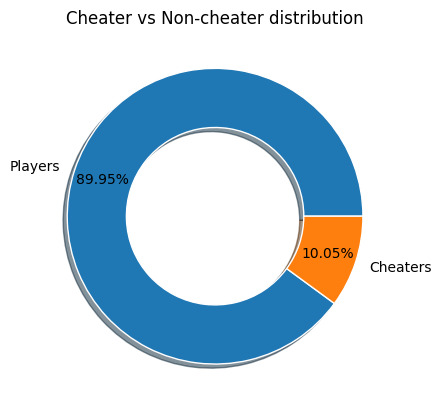

In [4]:
df['cheater'].value_counts(normalize=True).plot(kind='pie',
                                                autopct = '%1.2f%%',
                                                ylabel='',
                                                title='Cheater vs Non-cheater distribution',

                                                wedgeprops=dict(width=0.4, edgecolor='w'),
                                                shadow = True,
                                                pctdistance = 0.8,
                                                labels = ['Players', 'Cheaters']
                                                )

### Visual exploration: how features vary with rank, by cheater flag

We will plot median trends for each numeric metric (except `rank` and `cheater`) across `rank`, separated by `cheater`.  
This helps to see which metrics differ between cheaters and non-cheaters as rank changes.


In [5]:
y_cols = list(df.columns.drop(['rank', 'cheater']))
y_cols


['scorePerMinute',
 'killsPerMinute',
 'winPercent',
 'killDeath',
 'quits',
 'accuracy',
 'headshots',
 'skill',
 'longestHeadShot',
 'highestKillStreak',
 'hoursPlayed',
 'kaPerKill',
 'healsPerDeath',
 'revivesPerDeath',
 'repairsPerDeath',
 'resuppliesPerDeath']

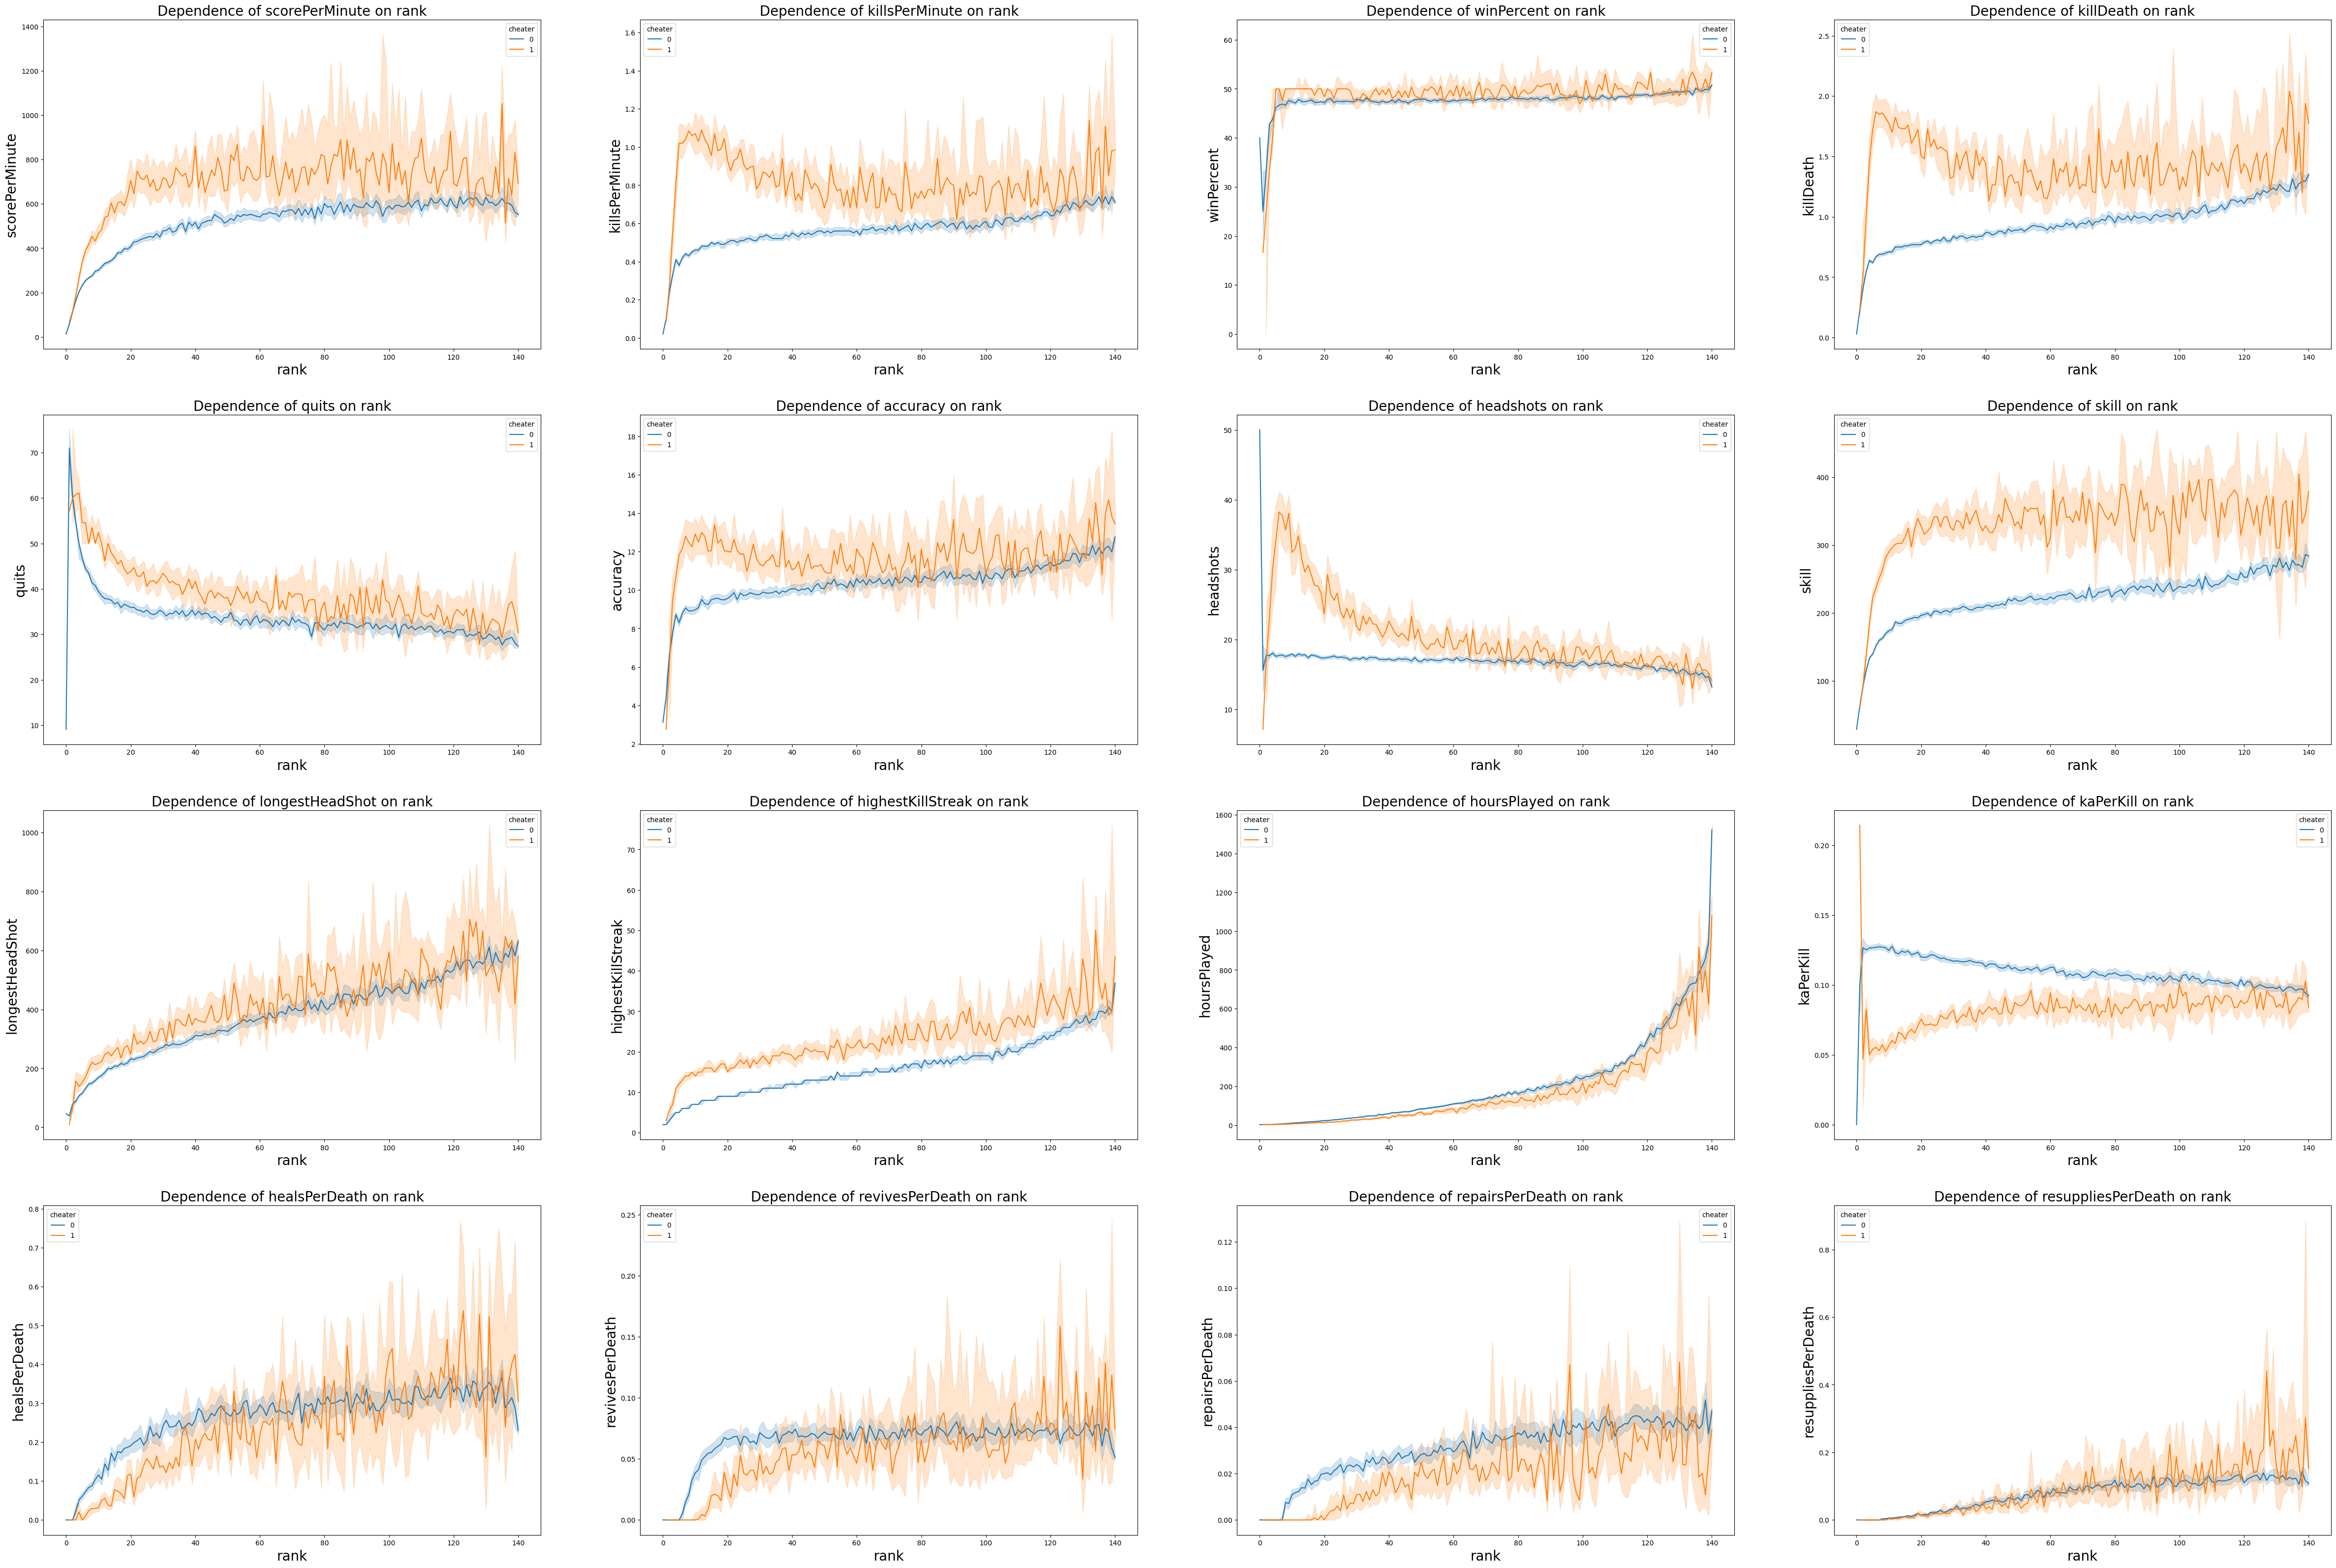

In [6]:
fig, axes = plt.subplots(4, 4, figsize=(60, 40))
for i, y_col in enumerate(y_cols):
    r, c = i//4, i%4
    sns.lineplot(x='rank', 
                 y=y_col, 
                 hue='cheater', 
                 data=df, 
                 ax=axes[r][c],
                 estimator='median') 
    
    axes[r][c].set_title(f'Dependence of {y_col} on rank', fontsize = 20)
    axes[r][c].set_xlabel('rank', fontsize = 20)
    axes[r][c].set_ylabel(y_col, fontsize = 20)


### Interpretation & cleanup

Visual inspection suggests some features are nearly identical or uninformative (very low variance / overlap between classes).
We will drop those observed-to-be-redundant columns to simplify the dataset before saving.  

In [7]:
df = df.drop(columns=['longestHeadShot', 'hoursPlayed', 'healsPerDeath', 'revivesPerDeath', 'resuppliesPerDeath'])
df.to_csv('data/ready.csv')